In [1]:
import pandas_datareader as pdr
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [2]:
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2021, 4, 30)
YEARS = (END - START).days/ 365.25

In [3]:
#define starting variables
STARTING_BALANCE = 10000
PCT_THRESH = 75

In [4]:
#download data
price = pdr.get_data_yahoo('^NSEBANK', START, END)

price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-09-17,6977.200195,6843.000000,6898.000000,6897.100098,0.0,6897.100098
2007-09-18,7078.950195,6883.600098,6921.149902,7059.649902,0.0,7059.649902
2007-09-19,7419.350098,7111.000000,7111.000000,7401.850098,0.0,7401.850098
2007-09-20,7462.899902,7343.600098,7404.950195,7390.149902,0.0,7390.149902
2007-09-21,7506.350098,7367.149902,7378.299805,7464.500000,0.0,7464.500000
...,...,...,...,...,...,...
2021-04-26,32603.699219,32144.800781,32316.650391,32275.150391,0.0,32275.150391
2021-04-27,32807.101562,32152.949219,32228.949219,32735.349609,0.0,32735.349609
2021-04-28,33777.699219,32840.300781,32865.500000,33722.800781,0.0,33722.800781


In [5]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], 1)

price.tail()

,High,Low,Open,Close
Date,,,,
2021-04-26,32603.699219,32144.800781,32316.650391,32275.150391
2021-04-27,32807.101562,32152.949219,32228.949219,32735.349609
2021-04-28,33777.699219,32840.300781,32865.500000,33722.800781
2021-04-29,34287.000000,33304.601562,33901.601562,33714.500000
2021-04-30,33455.250000,32663.400391,33112.398438,32781.800781


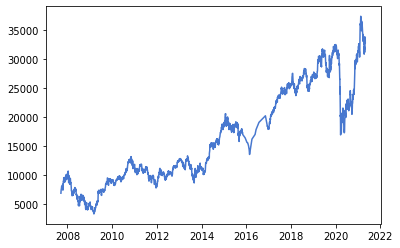

In [6]:
#plot chart
plt.style.use('seaborn-muted')
plt.plot(price.Close)
plt.show()

In [7]:
#calculate benchmark return and balance
#price['Return'] = price.Close / price.Close.shift(1)
price['Return'] = price.Open / price.Close.shift(1)

price.Return.iat[0] = 1
price = price.dropna()
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

In [8]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD
Date,,,,,,,,
2007-09-17,6977.200195,6843.000000,6898.000000,6897.100098,1.000000,10000.000000,10000.000000,0.000000
2007-09-18,7078.950195,6883.600098,6921.149902,7059.649902,1.003487,10034.869444,10034.869444,0.000000
2007-09-19,7419.350098,7111.000000,7111.000000,7401.850098,1.007274,10107.860532,10107.860532,0.000000
2007-09-20,7462.899902,7343.600098,7404.950195,7390.149902,1.000419,10112.093981,10112.093981,0.000000
2007-09-21,7506.350098,7367.149902,7378.299805,7464.500000,0.998397,10095.879249,10112.093981,-16.214732


In [9]:
bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd


-31.48

In [10]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2021-04-26,32603.699219,32144.800781,32316.650391,32275.150391,1.018736,399391.050708,416294.741049,-16903.690341,458.898438,130.349609,28.404893
2021-04-27,32807.101562,32152.949219,32228.949219,32735.349609,0.998569,398819.331154,416294.741049,-17475.409895,654.152344,582.400391,89.031308
2021-04-28,33777.699219,32840.300781,32865.500000,33722.800781,1.003976,400404.971520,416294.741049,-15889.769529,937.398438,882.500000,94.143532
2021-04-29,34287.000000,33304.601562,33901.601562,33714.500000,1.005302,402527.948262,416294.741049,-13766.792787,982.398438,409.898438,41.724256
2021-04-30,33455.250000,32663.400391,33112.398438,32781.800781,0.982141,395339.269605,416294.741049,-20955.471444,791.849609,118.400391,14.952384


"If close at high Pct = 100 and if close at low Pct = 0"

In [11]:
#identify entries and allocate trading fees
price['Long'] = price.Pct > PCT_THRESH


In [12]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2007-09-17,6977.200195,6843.000000,6898.000000,6897.100098,1.000000,10000.000000,10000.000000,0.000000,134.200195,54.100098,40.312980,False,1.000000,10000.000000
2007-09-18,7078.950195,6883.600098,6921.149902,7059.649902,1.003487,10034.869444,10034.869444,0.000000,195.350098,176.049805,90.120152,True,1.000000,10000.000000
2007-09-19,7419.350098,7111.000000,7111.000000,7401.850098,1.007274,10107.860532,10107.860532,0.000000,308.350098,290.850098,94.324633,True,1.007274,10072.737456
2007-09-20,7462.899902,7343.600098,7404.950195,7390.149902,1.000419,10112.093981,10112.093981,0.000000,119.299805,46.549805,39.019179,False,1.000419,10076.956195
2007-09-21,7506.350098,7367.149902,7378.299805,7464.500000,0.998397,10095.879249,10112.093981,-16.214732,139.200195,97.350098,69.935317,False,1.000000,10076.956195


In [13]:
price['Sys_Bal_Cost'] = np.where(price['Long'].shift(1)==True,price['Sys_Bal']-(price['Sys_Bal']*0.001),price['Sys_Bal'])
price.head()


,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal,Sys_Bal_Cost
Date,,,,,,,,,,,,,,,
2007-09-17,6977.200195,6843.000000,6898.000000,6897.100098,1.000000,10000.000000,10000.000000,0.000000,134.200195,54.100098,40.312980,False,1.000000,10000.000000,10000.000000
2007-09-18,7078.950195,6883.600098,6921.149902,7059.649902,1.003487,10034.869444,10034.869444,0.000000,195.350098,176.049805,90.120152,True,1.000000,10000.000000,10000.000000
2007-09-19,7419.350098,7111.000000,7111.000000,7401.850098,1.007274,10107.860532,10107.860532,0.000000,308.350098,290.850098,94.324633,True,1.007274,10072.737456,10062.664719
2007-09-20,7462.899902,7343.600098,7404.950195,7390.149902,1.000419,10112.093981,10112.093981,0.000000,119.299805,46.549805,39.019179,False,1.000419,10076.956195,10066.879239
2007-09-21,7506.350098,7367.149902,7378.299805,7464.500000,0.998397,10095.879249,10112.093981,-16.214732,139.200195,97.350098,69.935317,False,1.000000,10076.956195,10076.956195


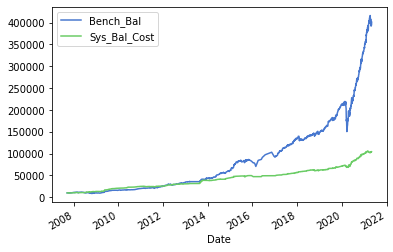

In [17]:
#plot balance
#plt.plot(price.Bench_Bal)
#plt.plot(price.Sys_Bal_Cost)
price[['Bench_Bal','Sys_Bal_Cost']].plot()
plt.show()


In [15]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal_Cost.cummax()
price['Sys_DD'] = price.Sys_Bal_Cost - price.Sys_Peak
price.head()

,High,Low,Open,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal,Sys_Bal_Cost,Sys_Peak,Sys_DD
Date,,,,,,,,,,,,,,,,,
2007-09-17,6977.200195,6843.000000,6898.000000,6897.100098,1.000000,10000.000000,10000.000000,0.000000,134.200195,54.100098,40.312980,False,1.000000,10000.000000,10000.000000,10000.000000,0.0
2007-09-18,7078.950195,6883.600098,6921.149902,7059.649902,1.003487,10034.869444,10034.869444,0.000000,195.350098,176.049805,90.120152,True,1.000000,10000.000000,10000.000000,10000.000000,0.0
2007-09-19,7419.350098,7111.000000,7111.000000,7401.850098,1.007274,10107.860532,10107.860532,0.000000,308.350098,290.850098,94.324633,True,1.007274,10072.737456,10062.664719,10062.664719,0.0
2007-09-20,7462.899902,7343.600098,7404.950195,7390.149902,1.000419,10112.093981,10112.093981,0.000000,119.299805,46.549805,39.019179,False,1.000419,10076.956195,10066.879239,10066.879239,0.0
2007-09-21,7506.350098,7367.149902,7378.299805,7464.500000,0.998397,10095.879249,10112.093981,-16.214732,139.200195,97.350098,69.935317,False,1.000000,10076.956195,10076.956195,10076.956195,0.0


In [16]:

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-7.59

In [18]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal_Cost[-1]/price.Sys_Bal_Cost[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal_Cost[-1]/price.Sys_Bal_Cost[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')


Benchmark Total return: 3853.39%
Benchmark CAGR: 18.82
Benchmark DD: -31.48%

System Total return: 942.85%
System CAGR: 11.62
System DD: -7.59%
Time in Market: 30%
Trades Won: 605
Trades Loss: 289
Winrate: 67.67%


In [73]:
symbols = ['^NSEBANK', '^NSEI', '^N225', '^GSPC', 'GC=F']

In [76]:
#create backtesting function
from operator import le, ge
#le= less than operator, ge=greater than operator

def backtest(symbol, PCT_THR=20, logical=le):
    #download data
    price = pdr.get_data_yahoo(symbol, START, END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], 1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    #price['Return'] = price.Open / price.Close.shift(1)
    price.Return.iat[0] = 1
    price = price.dropna()
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    #price['Long'] = price.Pct > PCT_THR
    price['Long'] = logical(price.Pct, PCT_THR)
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    price['Sys_Bal_Cost'] = np.where(price['Long'].shift(1)==True,
                                     price['Sys_Bal']-(price['Sys_Bal']*0.001),
                                     price['Sys_Bal'])
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal_Cost.cummax()
    price['Sys_DD'] = price.Sys_Bal_Cost - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal_Cost[-1]/price.Sys_Bal_Cost[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr, bench_dd, sys_dd

In [77]:
#backtest multiple symbols
bc = []
sc = []
bdd =[]
sysdd=[]

for symbol in symbols:
    bench_cagr, sys_cagr, bench_dd, sys_dd = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)
    bdd.append(bench_dd)
    sysdd.append(sys_dd)

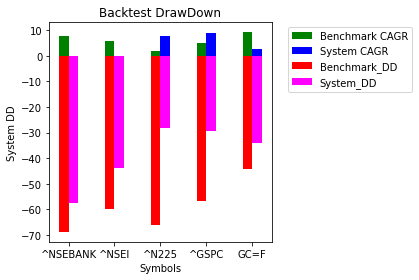

In [78]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, color='green', label = 'Benchmark CAGR')
plt.bar(x_indices + width / 2, sc, width = width, color = 'blue', label = 'System CAGR')
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')

plt.bar(x_indices - width / 2, bdd, width = width, color='red',label = 'Benchmark_DD')
plt.bar(x_indices + width / 2, sysdd, width = width, color='magenta', label = 'System_DD')
   
plt.xticks(ticks = x_indices, labels = symbols)



plt.title('Backtest DrawDown')
plt.xlabel('Symbols')
plt.ylabel('System DD')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.show()